# Example climb: Low Pearson correlation & low entropy

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, entropy

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 5000

# Run duration in minutes
run_time = 60 * 7

# Number of replicate climbs for each objective function
replicates = 8

# Hill climb parameters
step_size = 0.05
perturb_fraction = 0.05
temperature = 1000
initial_noise = 0.2
cooling_rate = 0.9999

### 1.3. Input distributions

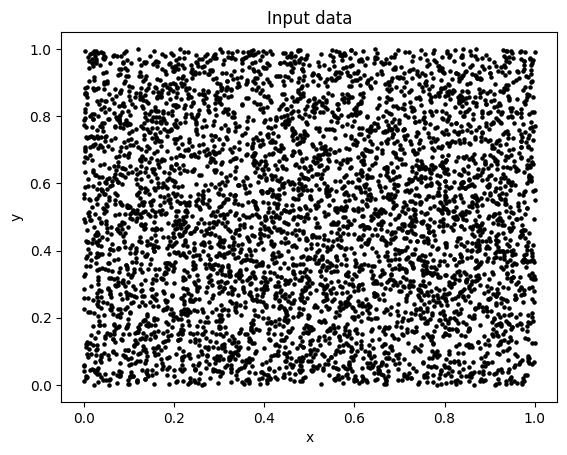

In [3]:
# Create input distribution
data = pd.DataFrame({
    'x': np.random.rand(n),
    'y': np.random.rand(n)
})

plt.title('Input data')
plt.scatter(data['x'], data['y'], s=5, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Minimize correlation and entropy

### 2.1. Objective function

In [4]:
def edge_concentration_penalty(data, edge_threshold=0.05):
    """Penalize having too many points near the edges [0, 1]"""
    try:
        if len(data) < 3:
            return 0.0
        
        # Count points very close to 0 or 1
        near_zero = np.sum(data < edge_threshold)
        near_one = np.sum(data > (1.0 - edge_threshold))
        edge_count = near_zero + near_one
        
        # Penalty increases with edge concentration
        edge_fraction = edge_count / len(data)
        
        # Penalize if more than 20% of points are on edges
        if edge_fraction > 0.2:
            return (edge_fraction - 0.2) * 5.0  # Strong penalty
        return 0.0
        
    except:
        return 0.0


def outlier_penalty(data):
    try:
        if len(data) < 3:
            return 0.0

        mean_val = np.mean(data)
        std_val = np.std(data)

        if std_val == 0:
            return 0.0

        # Count points more than 2.5 standard deviations from mean
        z_scores = np.abs((data - mean_val) / std_val)
        outliers = np.sum(z_scores > 2.5)
        return outliers / len(data)

    except:
        return 0.0


def clustering_reward(x, y):
    """Reward configurations with clustered points (low entropy patterns)"""
    try:
        # Use smaller grid for stronger clustering signal
        n_grid = 8
        grid_counts = np.zeros((n_grid, n_grid))
        
        # Bin points into grid
        x_bins = np.digitize(x, np.linspace(0, 1, n_grid + 1)) - 1
        y_bins = np.digitize(y, np.linspace(0, 1, n_grid + 1)) - 1
        
        # Clip to valid range
        x_bins = np.clip(x_bins, 0, n_grid - 1)
        y_bins = np.clip(y_bins, 0, n_grid - 1)
        
        # Count points in each grid cell
        for i in range(len(x)):
            grid_counts[x_bins[i], y_bins[i]] += 1
        
        # Calculate what fraction of cells are occupied
        occupied_cells = np.sum(grid_counts > 0)
        total_cells = n_grid * n_grid
        occupancy_fraction = occupied_cells / total_cells
        
        # Lower occupancy = more clustering (reward this)
        clustering_score = 1.0 - occupancy_fraction
        
        # Also reward high variance in occupied cells (some very dense, some empty)
        if occupied_cells > 0:
            density_variance = np.std(grid_counts[grid_counts > 0])
            clustering_score += density_variance / 100.0  # Normalized contribution
        
        return clustering_score
        
    except:
        return 0.0


def objective_low_correlation_low_entropy(x, y):
    '''Minimize both Pearson correlation and joint entropy while encouraging clustering.
    
    Low entropy is achieved through clustered/concentrated point distributions.
    '''

    # Convert to numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Basic validation
    if len(x) == 0 or len(y) == 0 or len(x) != len(y):
        return {'error': 'invalid_input'}, -1000.0
    
    # Calculate Pearson correlation (with fallback)
    try:
        pearson_corr = pearsonr(x, y)[0]

        if np.isnan(pearson_corr):
            pearson_corr = 0.0

    except:
        pearson_corr = 0.0
    
    # Calculate joint entropy using 2D histogram
    try:
        n_bins = 20  # Reduced bins for stronger signal
        hist_2d, _, _ = np.histogram2d(x, y, bins=n_bins)
        hist_flat = hist_2d.flatten()
        
        if hist_flat.sum() == 0:
            joint_entropy = 0.0

        else:
            hist_prob = hist_flat / hist_flat.sum()
            joint_entropy = entropy(hist_prob + 1e-10)
            
    except:
        joint_entropy = 5.0
    
    # Calculate clustering reward (want high - means concentrated distribution)
    clustering_score = clustering_reward(x, y)
    
    # Calculate compactness - reward distributions that don't fill entire space
    x_range = np.ptp(x)
    y_range = np.ptp(y)
    avg_range = (x_range + y_range) / 2.0
    
    # Reward more compact distributions (smaller range)
    compactness_reward = max(0, 0.8 - avg_range)  # Reward if range < 0.8
    
    # Edge concentration check (for metrics only, light penalty)
    edge_penalty_x = edge_concentration_penalty(x, edge_threshold=0.03)
    edge_penalty_y = edge_concentration_penalty(y, edge_threshold=0.03)
    total_edge_penalty = edge_penalty_x + edge_penalty_y
    
    # Strong entropy penalty - this is the main objective
    entropy_penalty = 5.0 * joint_entropy  # Much stronger weight
    
    # Moderate correlation penalty
    correlation_penalty = 1.5 * abs(pearson_corr)
    
    # Strong clustering reward
    clustering_reward_weighted = 4.0 * clustering_score
    
    # Moderate compactness reward
    compactness_reward_weighted = 2.0 * compactness_reward
    
    # Light edge penalty (just to avoid pathological edge-hugging)
    edge_penalty_weighted = 1.0 * total_edge_penalty
    
    # Calculate objective: minimize entropy and correlation, maximize clustering
    objective = -(entropy_penalty + correlation_penalty + edge_penalty_weighted) + \
                clustering_reward_weighted + compactness_reward_weighted
    
    metrics = {
        'Pearson coefficient': float(pearson_corr),
        'Joint Entropy': float(joint_entropy),
        'Clustering Score': float(clustering_score),
        'Compactness Reward': float(compactness_reward),
        'Avg Range': float(avg_range),
        'Edge Penalty': float(total_edge_penalty),
        'Entropy Penalty': float(entropy_penalty),
        'Clustering Reward': float(clustering_reward_weighted)
    }
    
    return metrics, float(objective)

### 2.2. Hill climbing run

In [5]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_low_correlation_low_entropy,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.3. Results

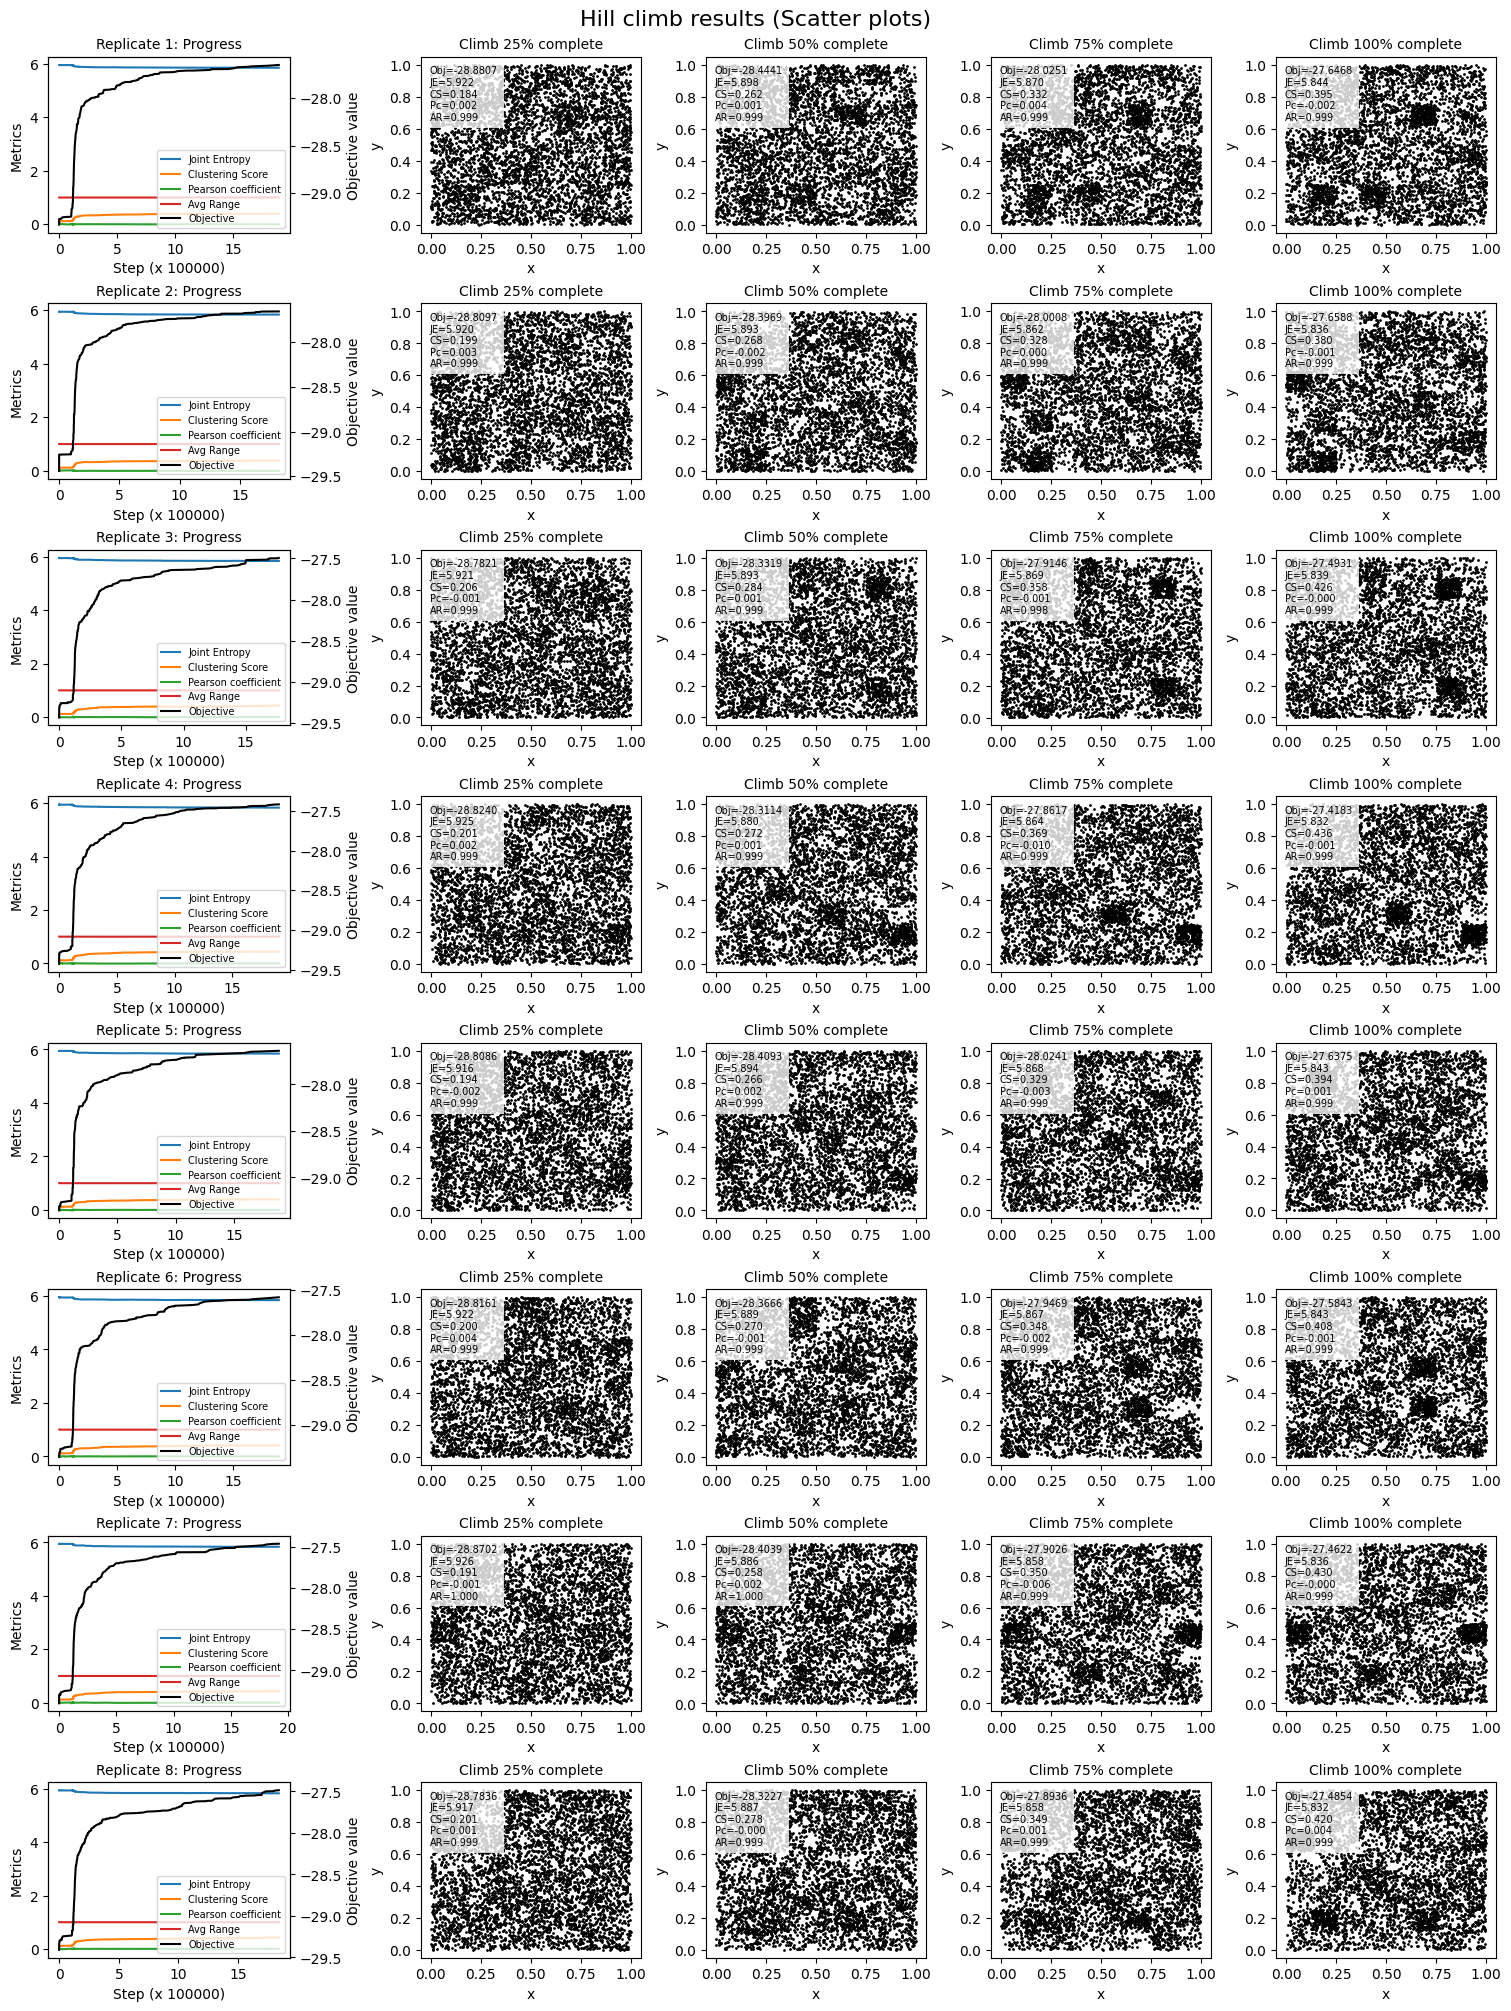

In [6]:
# Display key metrics for entropy reduction and clustering
climber.plot_results(
    results,
    metrics=[
        'Joint Entropy',
        'Clustering Score',
        'Pearson coefficient',
        'Avg Range'
    ]
)

In [7]:
# Save the climber object
with open('../data/04_low_correlation_low_entropy.pkl', 'wb') as f:
    pickle.dump(climber, f)

## 3. Resume with refined parameters

### 3.1. Updated hyperparameters for continued optimization

In [9]:
# Updated parameters for refined optimization
new_step_size = 0.01
new_perturb_fraction = 0.1
new_temperature = 1000  # Reset temperature
additional_run_time = 2 * 60  # 2 hours

print(f"Original step_size: {step_size}")
print(f"New step_size: {new_step_size}")
print(f"Original perturb_fraction: {perturb_fraction}")
print(f"New perturb_fraction: {new_perturb_fraction}")
print(f"Original temperature: {temperature}")
print(f"New temperature: {new_temperature}")
print(f"Additional run time: {additional_run_time / 60} hours")

Original step_size: 0.05
New step_size: 0.01
Original perturb_fraction: 0.05
New perturb_fraction: 0.1
Original temperature: 1000
New temperature: 1000
Additional run time: 2.0 hours


### 3.2. Resume hill climbing with refined parameters

In [11]:
# Update the climber with new parameters
climber.step_size = new_step_size
climber.perturb_fraction = new_perturb_fraction
climber.temperature = new_temperature
climber.max_time = additional_run_time

print(f"Resuming optimization with:")
print(f"  - step_size: {climber.step_size}")
print(f"  - perturb_fraction: {climber.perturb_fraction}")
print(f"  - temperature: {climber.temperature}")
print(f"  - max_time: {climber.max_time} minutes ({climber.max_time / 60} hours)")
print(f"  - replicates: {replicates}")

# Resume parallel optimization with updated parameters
resumed_results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

Resuming optimization with:
  - step_size: 0.01
  - perturb_fraction: 0.1
  - temperature: 1000
  - max_time: 120 seconds (2.0 hours)
  - replicates: 8


### 3.3. Resumed results analysis

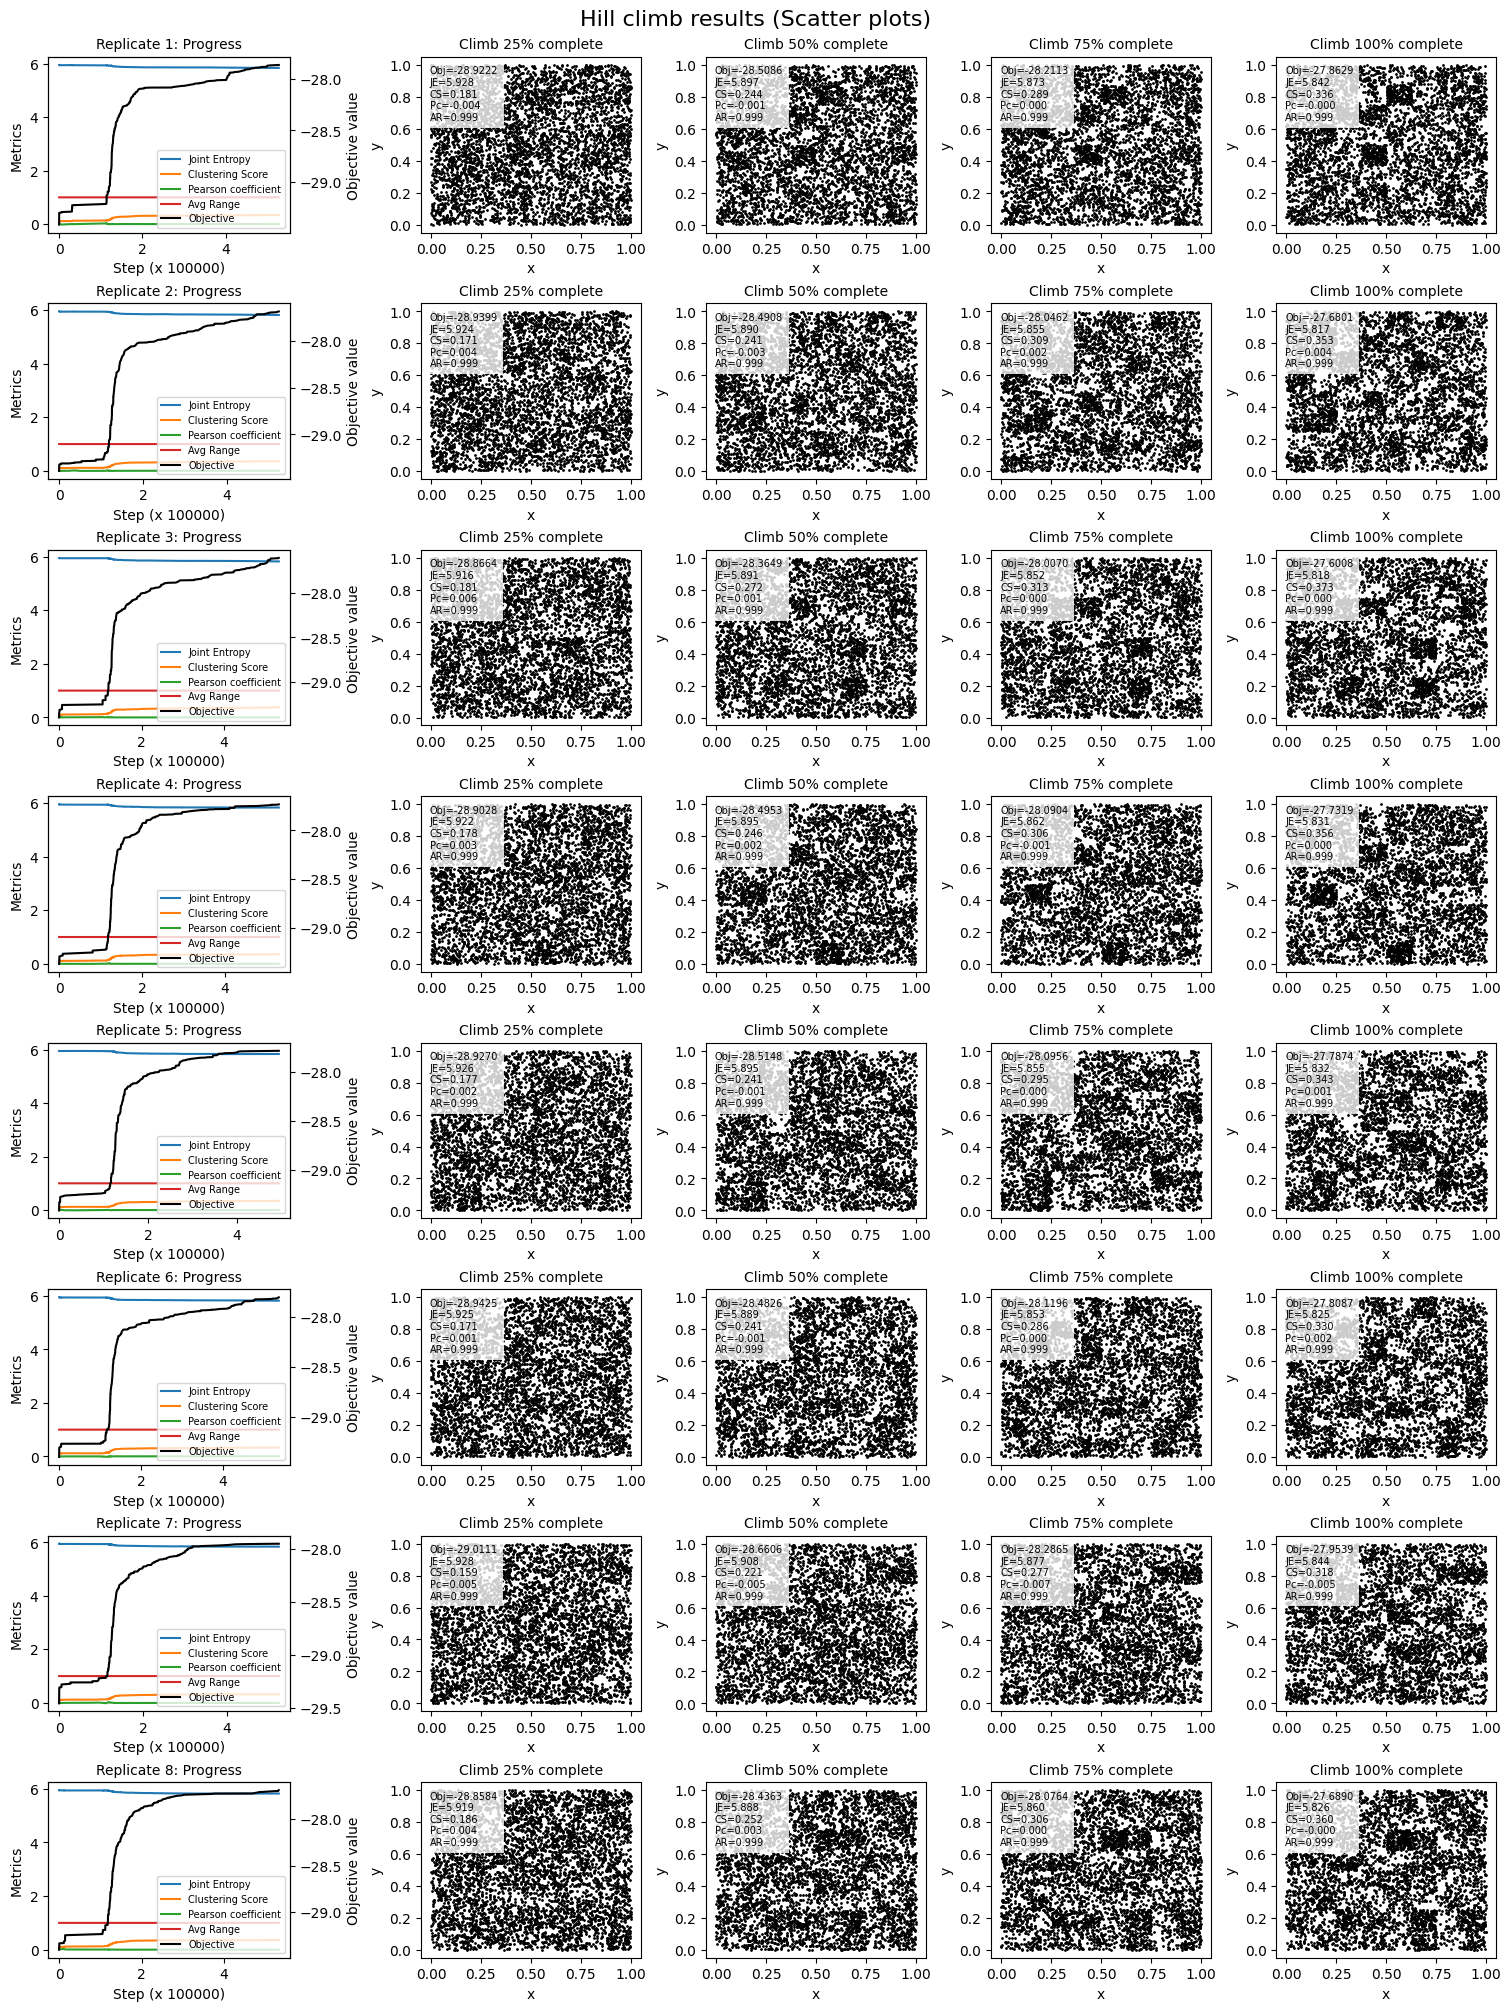

In [13]:
# Plot results from the resumed optimization
climber.plot_results(
    resumed_results,
    metrics=[
        'Joint Entropy',
        'Clustering Score',
        'Pearson coefficient',
        'Avg Range'
    ]
)

In [ ]:
# Save the updated climber object with resumed results
with open('../data/04_low_correlation_low_entropy_resumed.pkl', 'wb') as f:
    pickle.dump(climber, f)

print("Climber object with resumed results saved to '../data/04_low_correlation_low_entropy_resumed.pkl'")